In [4]:
import os
import sys
sys.path.insert(1, os.getcwd())

import numpy as np
import rasterio
import rioxarray
import xarray as xr
import pandas as pd
from datetime import datetime, timezone, timedelta
from matplotlib import pyplot as plt

from sinosoidal_regression import sinusoidal_regression
import energy_balance_model as eb

In [5]:
LST_folder = os.path.join(os.getcwd(), 'data',  'LandSurfaceTemperature')
WR_folder = os.path.join(os.getcwd(), 'data',  'warmingrate')
cast_shadow_folder=os.path.join(os.getcwd(), 'data', 'AdditionalDatasets','CastShadowSurroundingTerrain')

LST_paths = [os.path.join(LST_folder, i) for i in os.listdir(LST_folder)]
WR_paths = [os.path.join(WR_folder, i) for i in os.listdir(WR_folder)]
castshadow_paths = [os.path.join(cast_shadow_folder, i) for i in os.listdir(cast_shadow_folder)]

Era5_Land_path = os.path.join(os.getcwd(), 'data', 'ERA5_Land_aoi.csv')
DEM_path = os.path.join(os.getcwd(), 'data', 'AdditionalDatasets', '20190830_DEM.tif')
class_path = os.path.join(os.getcwd(), 'data', 'AdditionalDatasets', 'classTIR_19.tif')

In [6]:
tmz=2 # conversion to utc
   
dtobj_list=pd.Series(
    [datetime(2019, 8, 30, 9, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 11, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 13, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 15, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 17, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 19, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 21, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz),
    datetime(2019, 8, 30, 22, 0, 0).replace(tzinfo=timezone.utc) - timedelta(hours = tmz)])

## Load Datasets

Read Era5 csv (previously extracted from netcdf file at loacation of TN Glacier)

In [7]:
Era5_Land_subset = pd.read_csv(Era5_Land_path, index_col = 'datetime') # read ERA5 from csv
Era5_Land_subset.index = pd.to_datetime(Era5_Land_subset.index).rename('time') # make datetime to index
Era5_Land_subset = Era5_Land_subset[Era5_Land_subset.index.isin(dtobj_list)] # subset data to time of flights
Era5_Land_subset['rh'] = eb.relative_humidity(Era5_Land_subset['t2mC'], Era5_Land_subset['d2mC']) # calculate relative humidity from dew point and air tempertaure
Era5_Land_subset=Era5_Land_subset.rename({'slhf':'SurfaceLatentHeatFlux', 
                                          'ssr':'SurfaceSolarRadiation', 
                                          'str':'SurfaceNetThermalRadiation',
                                          'sshf':'SurfaceSensibleHeatFlux',
                                          'ssrd':'SurfaceSolarRadiationDownwards', 
                                          'strd':'LWin', 
                                          't2mC':'AirTemperature', 
                                          'd2mC':'DewTemperature'}, axis=1) # rename ERA5 columns

Creates a xarray dataset and merges with ERA5

In [8]:
time_var = xr.Variable('time', dtobj_list)
dataset = xr.concat([xr.open_rasterio(i) for i in LST_paths], dim=time_var).to_dataset('band').rename({1: 'LST'})
dataset = xr.merge([dataset, Era5_Land_subset.to_xarray()]) 

Load warming rate files as list of 2darrays

In [9]:
wr_maps = [rasterio.open(i).read(1)for i in WR_paths]

In [10]:
dataset['WR']=xr.DataArray(data=wr_maps, dims=["time", "y", "x"])
dataset['WR']=xr.where(dataset['WR']==-0, np.nan, dataset['WR']) #nodata area to NaN

Load cast shadow files as list of 2darrays

In [11]:
castshadows = [rasterio.open(i).read(1)for i in castshadow_paths]

Load DEM with nodata values as np.nan

In [12]:
DEM = rasterio.open(DEM_path).read(1)
nodata_bool = np.array(DEM==-32767)
DEM[nodata_bool] = np.nan

Load ice/debris image segmentation file 

In [13]:
ice_debris_segmentation = rasterio.open(class_path).read(1)

## Surface Energy Balance Model

In [14]:
flight_times = [9, 11, 13, 15, 17, 19, 21, 22]
lat = 46.012 
lon = 7.47

parameter = {'albedo_d': 0.3,
             'albedo_i': 0.64,
             'emiss_d': 0.94,
             'emiss_i': 0.97,
             'k_eff': 0.96,
             'z0': 0.016,
             'zu': 10,
             'zt': 2,
             'density_d': 1496,
             'c_d': 948}

In [15]:
emissivity = np.zeros(ice_debris_segmentation.shape)
emissivity[ice_debris_segmentation==1]=parameter['emiss_i']  
emissivity[ice_debris_segmentation==0]=parameter['emiss_d']  
emissivity[nodata_bool] = np.nan

In [16]:
albedo = np.zeros(ice_debris_segmentation.shape)
albedo[ice_debris_segmentation==1]=parameter['albedo_i'] 
albedo[ice_debris_segmentation==0]=parameter['albedo_d']
albedo[nodata_bool] = np.nan

In [17]:
dataset['LWout'] = eb.calc_lout(emissivity, dataset.LST).transpose("time", "y", "x") 
dataset['LWnet'] = eb.calc_lnet(dataset.LWin, dataset.LWout) 

In [18]:
swin=[]
for n,i in enumerate(dtobj_list):
    print(i)
    sin = eb.calc_sin(dt_object=i,
                      latitude=lat,
                      longitude=lon,
                      timezone=1, 
                      dem=DEM, 
                      res=dataset.attrs['transform'][0], 
                      relhum=dataset.rh.values[n], 
                      TairK=dataset.AirTemperature.values[n]+273.15,  
                      shadow_surrounding=castshadows[n])
    swin.append(sin)
    print()

2019-08-30 07:00:00+00:00
zenith: 78.44595143054319
Id:  457.60799188988545
In:  69.928327597518

2019-08-30 09:00:00+00:00
zenith: 58.093433758115445
Id:  772.6380831411692
In:  112.88272580337568

2019-08-30 11:00:00+00:00
zenith: 41.8010123937845
Id:  864.4495874062616
In:  127.62931137949019

2019-08-30 13:00:00+00:00
zenith: 37.55152511145905
Id:  879.0506332914752
In:  130.25635666764322

2019-08-30 15:00:00+00:00
zenith: 48.87218570276142
Id:  831.0175593410412
In:  121.99425732532727

2019-08-30 17:00:00+00:00
zenith: 67.89224727647722
Id:  670.6747751611584
In:  98.46872803182357

2019-08-30 19:00:00+00:00
zenith: 88.62795579078193
Id:  52.408703112842076
In:  5.0235667598582525

2019-08-30 20:00:00+00:00
zenith: 98.59551960981355
Id:  0
In:  0



D:\COLD\sebm_paper\frontiers_submission\04_UAV_SEBM\energy_balance_model.py:344: RuntimeWarning: invalid value encountered in double_scalars
  Mr = 1.0/(np.cos(theta)+0.15*((93.885-zenith)**(-1.253)))


In [19]:
dataset['SWin']  =  xr.DataArray(data=swin, dims=["time", "y", "x"])
dataset['SWnet'] = eb.calc_snet(albedo, dataset.SWin).transpose("time", "y", "x")

In [20]:
shf = eb.calc_shf(dataset.AirTemperature+273.15, dataset.LST+273.15, np.nanmean(DEM), dataset.wind, parameter['zt'], parameter['zu'], parameter['z0'])
dataset['H'] = shf.transpose("time", "y", "x")

In [21]:
debris_thickness=[]
for n,i in enumerate(dtobj_list):
    print(i)
    dc= eb.debristhickness_prediction(sw=dataset.SWnet.values[n],
                                          lw=dataset.LWnet.values[n],
                                          H=dataset.H.values[n],
                                          Ts=dataset.LST.values[n],
                                          Ta=dataset.AirTemperature.values[n],
                                          w_rate=dataset.WR.values[n], 
                                          params=parameter)
    debris_thickness.append(dc)

2019-08-30 07:00:00+00:00


D:\COLD\sebm_paper\frontiers_submission\04_UAV_SEBM\energy_balance_model.py:470: RuntimeWarning: invalid value encountered in sqrt
  x0 = (-b + np.sqrt(D)) / (2*a)
D:\COLD\sebm_paper\frontiers_submission\04_UAV_SEBM\energy_balance_model.py:471: RuntimeWarning: invalid value encountered in sqrt
  x1 = (-b - np.sqrt(D)) / (2*a)


2019-08-30 09:00:00+00:00
2019-08-30 11:00:00+00:00
2019-08-30 13:00:00+00:00
2019-08-30 15:00:00+00:00
2019-08-30 17:00:00+00:00
2019-08-30 19:00:00+00:00
2019-08-30 20:00:00+00:00


In [22]:
dataset['d_thickness'] = (['time', 'y', 'x'], debris_thickness)

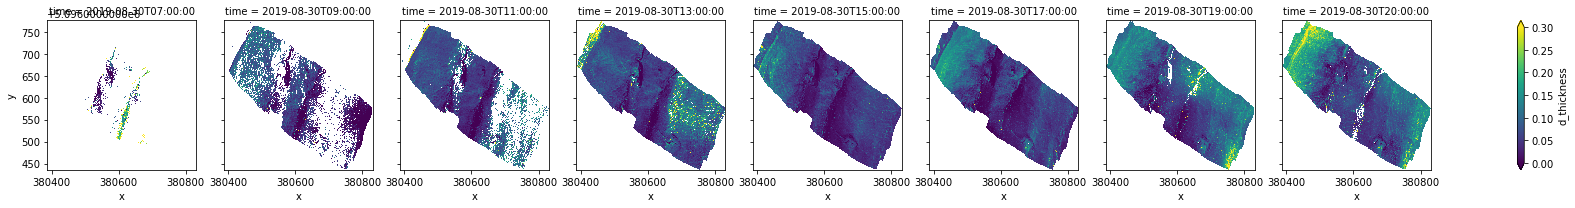

In [25]:
dataset.d_thickness.plot(col='time', vmin = 0, vmax = 0.3)

In [24]:
debris_path = os.path.join(os.getcwd(), 'results', 'debristhickness')

if not os.path.exists(debris_path):              
    os.makedirs(debris_path)

for n, i in enumerate(dataset.d_thickness):
    filename = 'debristhickness'+ '_' +dtobj_list[n].strftime("%Y%m%d_%H%M%S")+'.tif'
    dataset.d_thickness.isel(time=n).rio.to_raster(os.path.join(debris_path, filename))